In [10]:
############################################ Import Python Libraries Required ############################################ 
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.colors

import datetime
import os 
from os import path
import seaborn as sns
from scipy import signal

import warnings
warnings.filterwarnings('ignore')

import pickle

import statistics

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)
%config InlineBackend.figure_format = 'retina'



In [11]:
############################################ Initialize Parameters and Dataframes ############################################

NOWAVEPEAKDATE =  670
NOWAVEPEAKNUMBER = 2

## 1,Case to Infection Ratio -- KDP_nu -- -
KDP_nu_name=["CIR40" ,"CIR50"]
KDP_nu=[1,1.25]

## 2, Percentage transmission of immune-escape new variant --  KDP_w_sat_1  -- -
KDP_w_sat_1_name=["0_33" ,"0_66" ,"1_00"]
KDP_w_sat_1=[0.33, 0.66 ,1.00]

## 3, Emergence date of immune-escape new variant --  KDP_w_sat_2  -- -
KDP_w_sat_2_name=["ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov"]
KDP_w_sat_2=[380, 442 ,503]

## 4,Antibody waning population percentage  --  KDP_g_1  -- -
KDP_g_1_name=["0_33", "0_66" ,"1_00"]
KDP_g_1=[0.33, 0.66, 1.00]

## 5, Antibody waning period --  KDP_g_2  -- -
KDP_g_2_name=["ABW150Days" ,"ABW180Days"]
KDP_g_2=[150 ,180]

## 6, Vaccine Rate --  KDP_c_p  -- -
KDP_c_p_name=["Vaccine_PresentRate", "Vaccine_BestWeekAvg", "Vaccine_TwicePresent"]
KDP_c_p=[1 ,1.5, 2]

## 7, Social Distancing (COVID Appropriate Behaviour -> Good CAB = SD_RA, Partial CAB = SD_RAR, No CAB = SD_RARF ) --  KDP_c_p  -- -
KDP_lambda_name=["SD_RA","SD_RAR","SD_RARF"]
KDP_lambda=[0,0.1,0.2]

df_active = pd.read_pickle("Data_Files/df_active")
df_nucleation_total = pd.read_pickle("Data_Files/df_nucleation_total") # confirmed cases

df_nucleation_11 = pd.read_pickle("Data_Files/df_nucleation_11")
df_nucleation_18 = pd.read_pickle("Data_Files/df_nucleation_18")
df_nucleation_45 = pd.read_pickle("Data_Files/df_nucleation_45")
df_nucleation_60 = pd.read_pickle("Data_Files/df_nucleation_60")
df_nucleation_60plus = pd.read_pickle("Data_Files/df_nucleation_60plus")

df_antibody = pd.read_pickle("Data_Files/df_antibody")
df_Vaccinated = pd.read_pickle("Data_Files/df_Vaccinated")
df_nucleation_18plus = pd.read_pickle("Data_Files/df_nucleation_18plus")

with open('actual_Data.pkl', 'rb') as f: mynewlist = pickle.load(f) #actual number of active cases 



In [13]:
ensemble_mean = []

ensemble_sem = []
ensemble_ub = []
ensemble_lb = []

for i in range(731):
    ensemble_mean.append(np.mean(df_active.iloc[:,i]))
    
    ensemble_sem.append(scipy.stats.sem(df_active.iloc[:,i]))
    ensemble_ub.append(ensemble_mean[i]+ensemble_sem[i])
    ensemble_lb.append(ensemble_mean[i]-ensemble_sem[i])

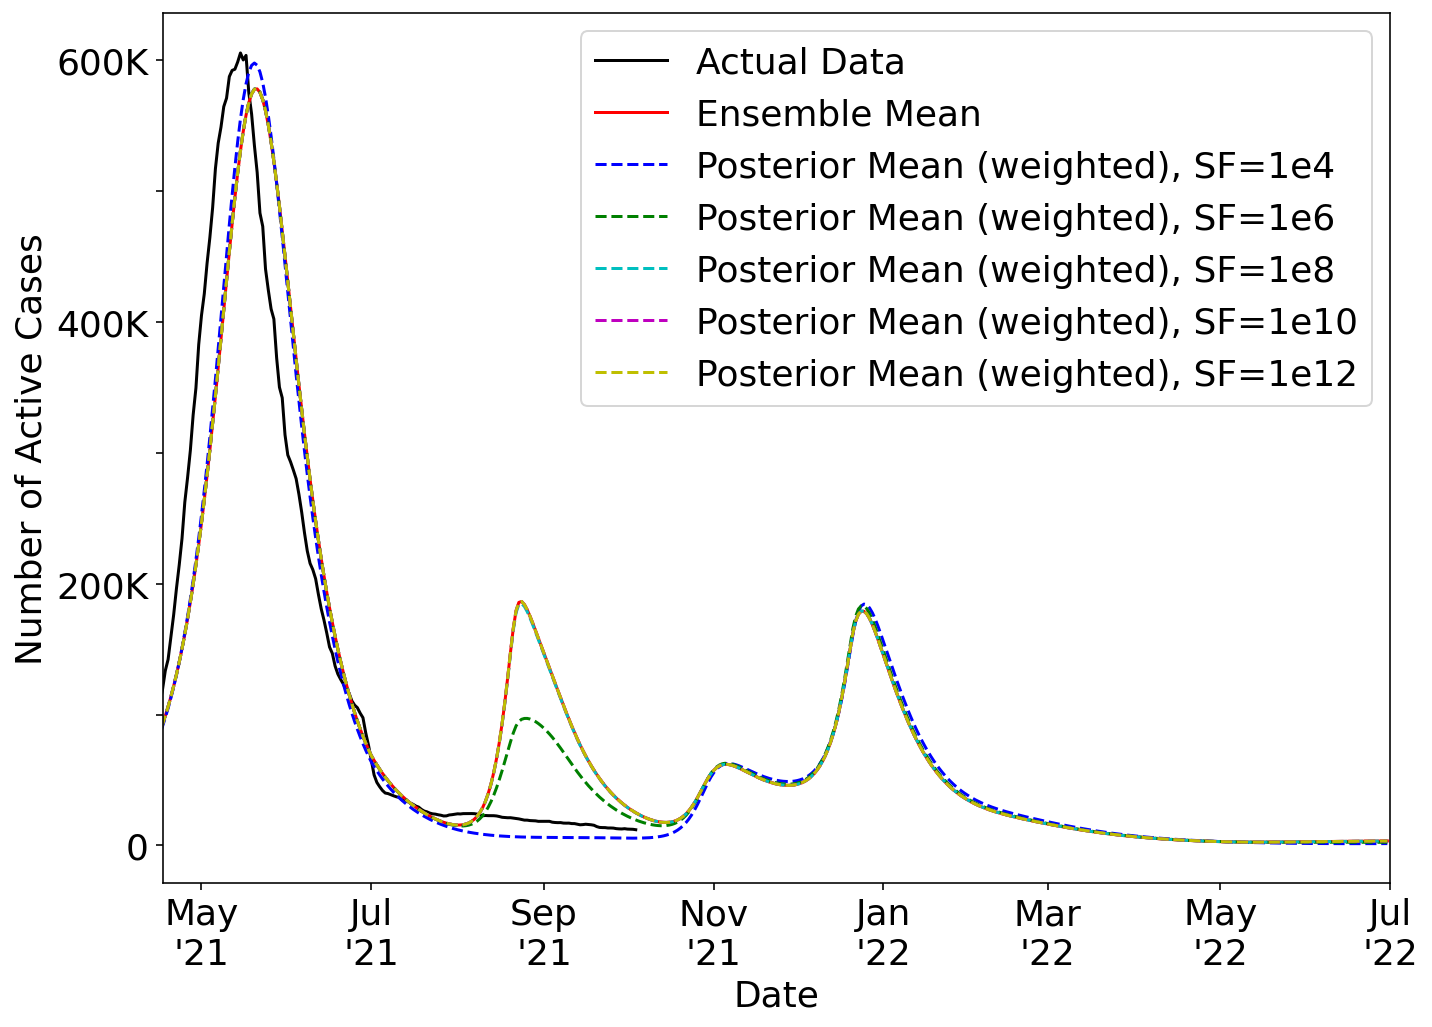

In [14]:
##### A Posteriori analysis - Effect of SF ########################################
import math 
N = 972
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize']=18

plt.figure(figsize=(11,8))
plt.rcParams["font.serif"]
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

startDay=301
xt = [304,365,427,488,549,608,670,731]   ## 1st days of the months hardcoded 
xtl = ['May\n\'21','Jul\n\'21','Sep\n\'21','Nov\n\'21', 'Jan\n\'22','Mar\n\'22','May\n\'22','Jul\n\'22']
yt=[0,1e5,2e5,3e5,4e5,5e5,6e5]
ytl=['0','','200K','','400K','','600K']
plt.plot(mynewlist['Actual'],'k-',label='Actual Data')
plt.plot(ensemble_mean,'r-', label='Ensemble Mean')

weightcum = []
weightpcum = []

S= [1e4,1e6,1e8,1e10,1e12]
Scolor = ['b','g','c','m','y']
Slabel = ['Posterior Mean (weighted), SF=1e4','Posterior Mean (weighted), SF=1e6','Posterior Mean (weighted), SF=1e8','Posterior Mean (weighted), SF=1e10','Posterior Mean (weighted), SF=1e12',]
D=0
for s in range(5):
    SF = S[s]
    weightp = np.zeros(N)

    weightr = np.zeros(N)
    weightr[:] = 1.0/N

    weightm = np.zeros(N)
    weightm[:] = 1.0/N

    weights = np.zeros(N)
    weights[:] = 1.0/N

    SSE = np.zeros(N)
    MSE = np.zeros(N)
    RMSE = np.zeros(N)

    for i in range(N):
        for j in range(0,len(mynewlist['Actual'])-D):
            MSE[i] += (((df_active.iloc[i,j]-mynewlist['Actual'][j])/SF)**2)/(len(mynewlist['Actual'])-D)
            SSE[i] += (((df_active.iloc[i,j]-mynewlist['Actual'][j])/SF)**2)
            
    for i in range(N):
        RMSE[i] = math.sqrt(MSE[i])
        weightr[i] = np.exp(-1.0*RMSE[i])*weightr[i]
        weightm[i] = np.exp(-1.0*MSE[i])*weightm[i]
        weights[i] = np.exp(-1.0*SSE[i])*weights[i]
        
    sum_weightr = sum(weightr)
    sum_weightm = sum(weightm)
    sum_weights = sum(weights)

    for i in range(N):
        weightr[i] = weightr[i]/sum_weightr
        weightm[i] = weightm[i]/sum_weightm
        weights[i] = weights[i]/sum_weights


    # print(sum(weightr),sum(weightm),sum(weights))

    df_posterior = df_active.copy(deep=True)
    df_posterior['WeightRMSE'] = weightr
    for i in range(N):
        for j in range(731):    
            df_posterior.iloc[i,j] = df_posterior.iloc[i,j]*df_posterior['WeightRMSE'][i]

            

    weighted_mean = []


    for i in range(731):
        
        weighted_mean.append(sum(df_posterior.iloc[:,i]))

    plt.plot(weighted_mean,color=Scolor[s],linestyle='dashed',label=Slabel[s])

plt.xlim([290,730])
plt.xticks(ticks=xt,labels=xtl)
plt.yticks(ticks=yt,labels=ytl)
plt.xlabel('Date')
plt.ylabel('Number of Active Cases')
plt.legend()
plt.savefig('Means.png',dpi=600, bbox_inches='tight')

In [29]:
##### A Posteriori analysis - Single SF ########################################
import math 
N = 972


weightrcum = []
weightpcum = []
weightmcum = []
weightscum = []

S = [1e4,1e6,1e12]

D = 0
for s in range(3):
    SF = S[s]
    weightp = np.zeros(N)

    weightr = np.zeros(N)
    weightr[:] = 1.0/N

    weightm = np.zeros(N)
    weightm[:] = 1.0/N

    weights = np.zeros(N)
    weights[:] = 1.0/N

    SSE = np.zeros(N)
    MSE = np.zeros(N)
    RMSE = np.zeros(N)

    for i in range(N):
        for j in range(0,len(mynewlist['Actual'])-D):
            MSE[i] += (((df_active.iloc[i,j]-mynewlist['Actual'][j])/SF)**2)/(len(mynewlist['Actual'])-D)
            SSE[i] += (((df_active.iloc[i,j]-mynewlist['Actual'][j])/SF)**2)
            
    for i in range(N):
        RMSE[i] = math.sqrt(MSE[i])
        weightr[i] = np.exp(-1.0*RMSE[i])*weightr[i]
        weightm[i] = np.exp(-1.0*MSE[i])*weightm[i]
        weights[i] = np.exp(-1.0*SSE[i])*weights[i]
        
    sum_weightr = sum(weightr)
    sum_weightm = sum(weightm)
    sum_weights = sum(weights)

    for i in range(N):
        weightr[i] = weightr[i]/sum_weightr
        weightm[i] = weightm[i]/sum_weightm
        weights[i] = weights[i]/sum_weights

    weightrcum.append(weightr)
    weightmcum.append(weightm)
    weightscum.append(weights)









In [53]:
weightscum[2]

array([0.00102881, 0.00102881, 0.00102881, 0.00102881, 0.00102881,
       0.00102881, 0.00102881, 0.00102881, 0.00102881, 0.00102881,
       0.00102881, 0.00102881, 0.00102881, 0.00102881, 0.00102881,
       0.00102881, 0.00102881, 0.00102881, 0.00102881, 0.00102881,
       0.00102881, 0.00102881, 0.00102881, 0.00102881, 0.00102881,
       0.00102881, 0.00102881, 0.00102881, 0.00102881, 0.00102881,
       0.00102881, 0.00102881, 0.00102881, 0.00102881, 0.00102881,
       0.00102881, 0.00102881, 0.00102881, 0.00102881, 0.00102881,
       0.00102881, 0.00102881, 0.00102881, 0.00102881, 0.00102881,
       0.00102881, 0.00102881, 0.00102881, 0.00102881, 0.00102881,
       0.00102881, 0.00102881, 0.00102881, 0.00102881, 0.00102881,
       0.00102881, 0.00102881, 0.00102881, 0.00102881, 0.00102881,
       0.00102881, 0.00102881, 0.00102881, 0.00102881, 0.00102881,
       0.00102881, 0.00102881, 0.00102881, 0.00102881, 0.00102881,
       0.00102881, 0.00102881, 0.00102881, 0.00102881, 0.00102

In [45]:
df_posterior = df_active.copy(deep=True)
df_posterior['WeightRMSE'] = weightrcum[0]
df_posterior['WeightMSE']=weightmcum[0]
df_posterior['WeightSSE']=weightscum[0]
df1= df_posterior.copy(deep=True)
df2= df_posterior.copy(deep=True)
df3= df_posterior.copy(deep=True)
for i in range(N):
    for j in range(731):    
        df1.iloc[i,j] = df1.iloc[i,j]*df1['WeightRMSE'][i]
        df2.iloc[i,j] = df2.iloc[i,j]*df2['WeightMSE'][i]
        df3.iloc[i,j] = df3.iloc[i,j]*df3['WeightSSE'][i]

            

weighted_meanr = []
weighted_meanm = []
weighted_means = []


for i in range(731):
    
    weighted_meanr.append(sum(df1.iloc[:,i]))
    weighted_meanm.append(sum(df2.iloc[:,i]))
    weighted_means.append(sum(df3.iloc[:,i]))

In [30]:
max_list = [i for i, j in enumerate(weightr) if j == max(weightr)]
max_list

[530, 539]

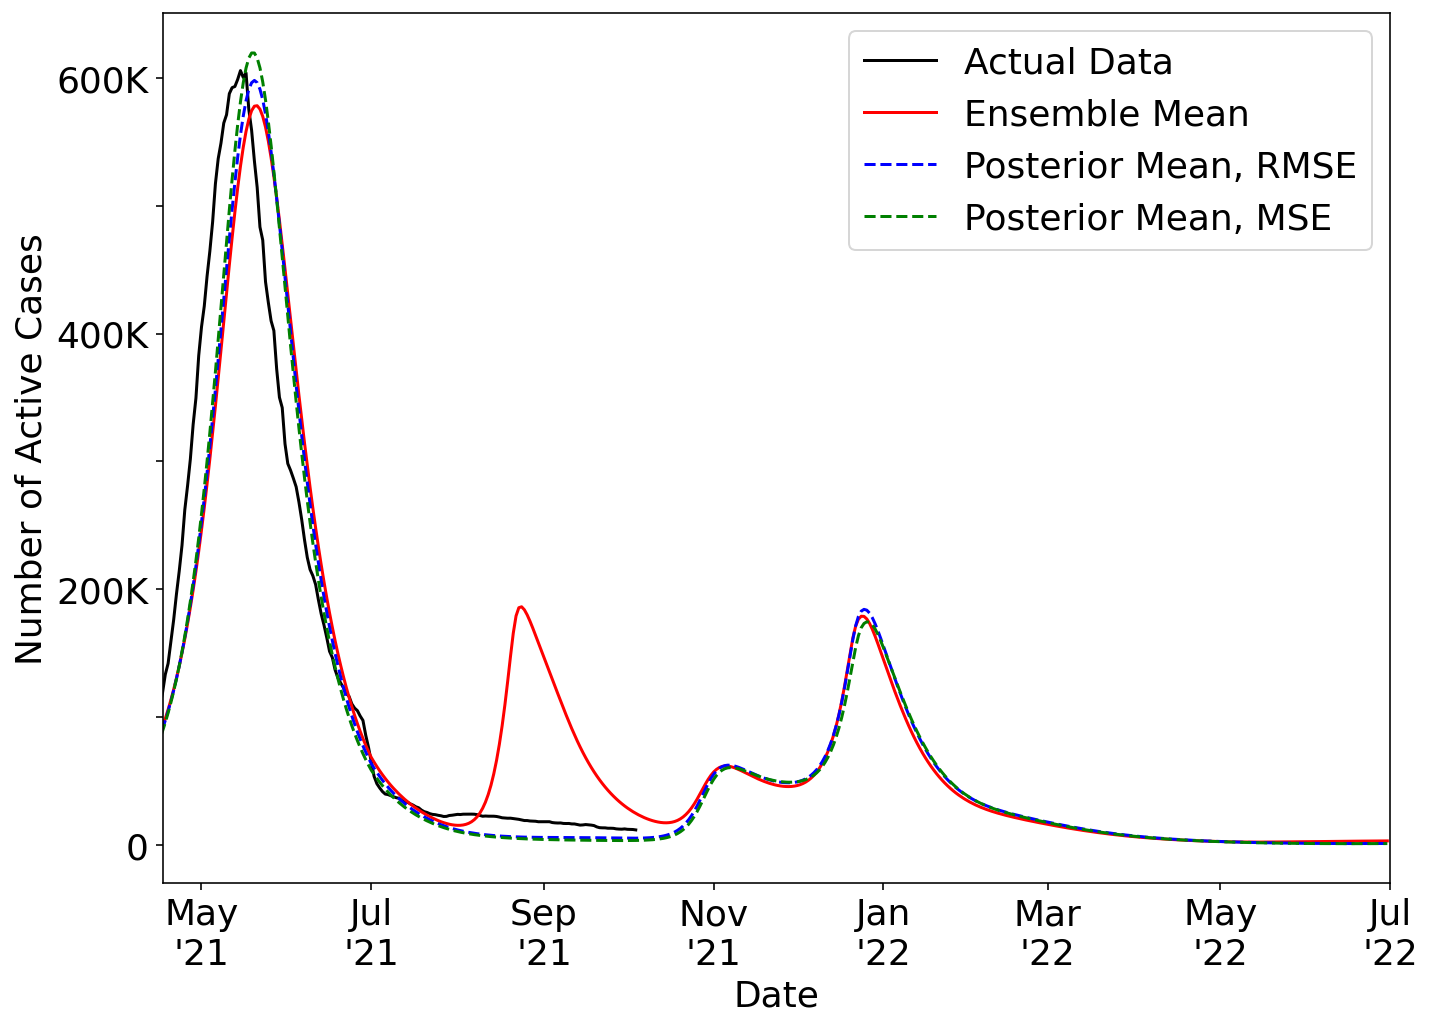

In [54]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize']=18

plt.figure(figsize=(11,8))
plt.rcParams["font.serif"]
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

startDay=301
xt = [304,365,427,488,549,608,670,731]   ## 1st days of the months hardcoded 
xtl = ['May\n\'21','Jul\n\'21','Sep\n\'21','Nov\n\'21', 'Jan\n\'22','Mar\n\'22','May\n\'22','Jul\n\'22']
yt=[0,1e5,2e5,3e5,4e5,5e5,6e5]
ytl=['0','','200K','','400K','','600K']
plt.plot(mynewlist['Actual'],'k-',label='Actual Data')
plt.plot(ensemble_mean,'r-', label='Ensemble Mean')

plt.plot(weighted_meanr,'b--',label='Posterior Mean, RMSE')
plt.plot(weighted_meanm,'g--',label='Posterior Mean, MSE')
# plt.plot(weighted_means,'m--',label='Posterior Mean, SSE')
plt.xlim([290,730])
plt.xticks(ticks=xt,labels=xtl)
plt.yticks(ticks=yt,labels=ytl)
plt.xlabel('Date')
plt.ylabel('Number of Active Cases')
plt.legend()


In [66]:
##### A Posteriori analysis - SErr########################################
import math 
N = 972



S = [1e4]

D = 0
for s in range(1):
    SF = S[s]
    weightp = np.zeros(N)

    weightr = np.zeros(N)
    weightr[:] = 1.0/N

    

    
    MSE = np.zeros(N)
    RMSE = np.zeros(N)

    for i in range(N):
        for j in range(0,len(mynewlist['Actual'])-D):
            MSE[i] += (((df_active.iloc[i,j]-mynewlist['Actual'][j])/SF)**2)/(len(mynewlist['Actual'])-D)
            
            
    for i in range(N):
        RMSE[i] = math.sqrt(MSE[i])
        weightr[i] = np.exp(-1.0*RMSE[i])*weightr[i]
        

    sum_weightr = sum(weightr)
    

    for i in range(N):
        weightr[i] = (weightr[i]/sum_weightr)*N
        
    
    df_posterior1 = df_active.copy(deep=True)
    df_posterior1['WeightRMSE'] = weightr
    for i in range(N):
        for j in range(731):    
            df_posterior1.iloc[i,j] = df_posterior1.iloc[i,j]*df_posterior1['WeightRMSE'][i]
    

    weighted_meanr1 = []
    weightedr1_sem = []
    weightedr1_ub = []
    weightedr1_lb = []



    for i in range(731):
        
        weighted_meanr1.append(np.mean(df_posterior1.iloc[:,i]))
        weightedr1_sem.append(scipy.stats.sem(df_posterior1.iloc[:,i]))
        weightedr1_ub.append(weighted_meanr1[i]+weightedr1_sem[i])
        weightedr1_lb.append(weighted_meanr1[i]-weightedr1_sem[i])
        
    
        
        





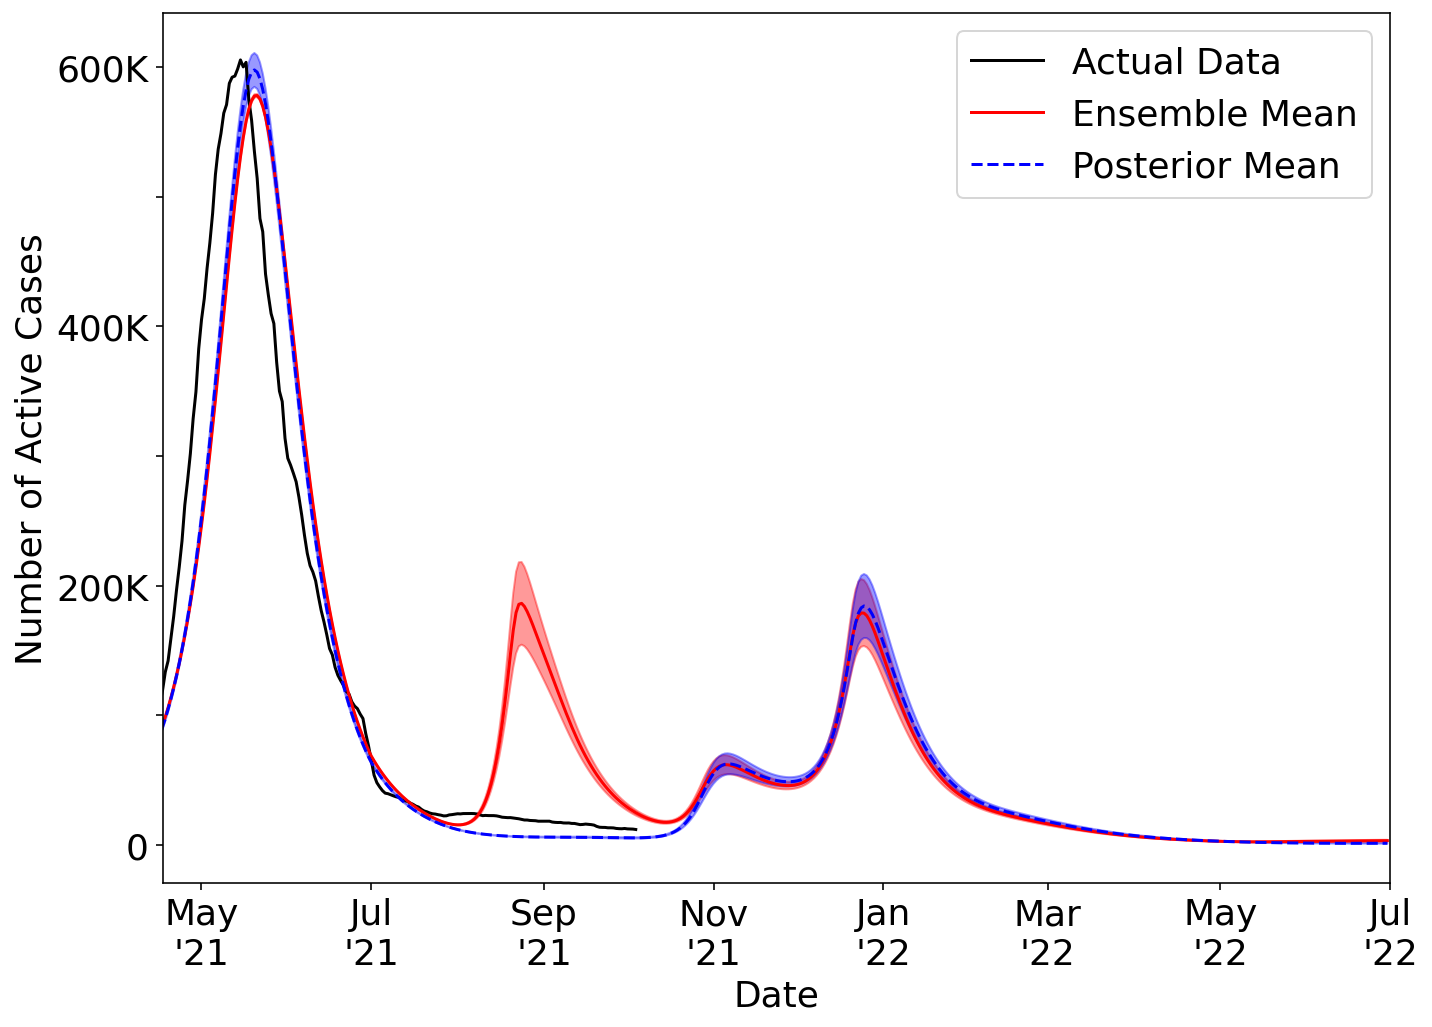

In [73]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize']=18

plt.figure(figsize=(11,8))
plt.rcParams["font.serif"]
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

startDay=301
xt = [304,365,427,488,549,608,670,731]   ## 1st days of the months hardcoded 
xtl = ['May\n\'21','Jul\n\'21','Sep\n\'21','Nov\n\'21', 'Jan\n\'22','Mar\n\'22','May\n\'22','Jul\n\'22']
yt=[0,1e5,2e5,3e5,4e5,5e5,6e5]
ytl=['0','','200K','','400K','','600K']
plt.plot(mynewlist['Actual'],'k-',label='Actual Data')
plt.plot(ensemble_mean,'r-', label='Ensemble Mean')
plt.fill_between(np.arange(731),ensemble_ub,ensemble_lb,color='r',alpha=0.4)
plt.plot(weighted_meanr1,'b--',label='Posterior Mean')
plt.fill_between(np.arange(731),weightedr1_ub,weightedr1_lb,color='b',alpha=0.4)
# plt.plot(weightedr1_ub,'y--',label='new')
# plt.plot(weightedr1_lb,'y--',label='new')
# plt.plot(weighted_meanr,'b--',label='Posterior Mean, RMSE')

# plt.plot(weighted_means,'m--',label='Posterior Mean, SSE')
plt.xlim([290,730])
plt.xticks(ticks=xt,labels=xtl)
plt.yticks(ticks=yt,labels=ytl)
plt.xlabel('Date')
plt.ylabel('Number of Active Cases')
plt.legend()

In [18]:
start ="2020-07-01"
end  = "2022-06-30"

start = datetime.datetime.strptime(start, "%Y-%m-%d")
end = datetime.datetime.strptime(end, "%Y-%m-%d")
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]



for i in range(len(date_generated)):
    date_generated[i] = date_generated[i].strftime("%d-%b-%y")

In [19]:
date_generated[461]

'05-Oct-21'

In [5]:
##### A Posteriori analysis - Single ########################################
import math 
N = 972


weightcum = []
weightpcum = []

SF = 1e6

D = 0
for D in range(10):
    weightp = np.zeros(N)

    weightr = np.zeros(N)
    weightr[:] = 1.0/N

    weightm = np.zeros(N)
    weightm[:] = 1.0/N

    weights = np.zeros(N)
    weights[:] = 1.0/N

    SSE = np.zeros(N)
    MSE = np.zeros(N)
    RMSE = np.zeros(N)

    for i in range(N):
        for j in range(0,len(mynewlist)-D):
            MSE[i] += (((df_active.iloc[i,j]-mynewlist[j])/SF)**2)/(len(mynewlist)-D-1)
            SSE[i] += (((df_active.iloc[i,j]-mynewlist[j])/SF)**2)
            
    for i in range(N):
        RMSE[i] = math.sqrt(MSE[i])
        weightr[i] = np.exp(-1.0*RMSE[i])*weightr[i]
        weightm[i] = np.exp(-1.0*MSE[i])*weightm[i]
        weights[i] = np.exp(-1.0*SSE[i])*weights[i]
        
    sum_weightr = sum(weightr)
    sum_weightm = sum(weightm)
    sum_weights = sum(weights)

    for i in range(N):
        weightr[i] = weightr[i]/sum_weightr
        weightm[i] = weightm[i]/sum_weightm
        weights[i] = weights[i]/sum_weights

    weightcum.append(weightr)
    p25 = np.percentile(weightr,25)
    p50 = np.percentile(weightr,50)
    p75 = np.percentile(weightr,75)
    
    max_list = [i for i, j in enumerate(weightr) if j == max(weightr)]


    for i in range(N):
        if(weightr[i]<p25):
            weightp[i]=0
        elif(p25<=weightr[i]<p50):
            weightp[i]=0.25
        elif(p50<=weightr[i]<p75):
            weightp[i]=0.5
        else:
            weightp[i]=0.75
        
    for i in max_list:
        weightp[i] = 1.0   

    weightpcum.append(weightp)






In [6]:
###MAP
m = max(weightr)
max_list = [i for i, j in enumerate(weightr) if j == m]


<Figure size 259.2x576 with 0 Axes>

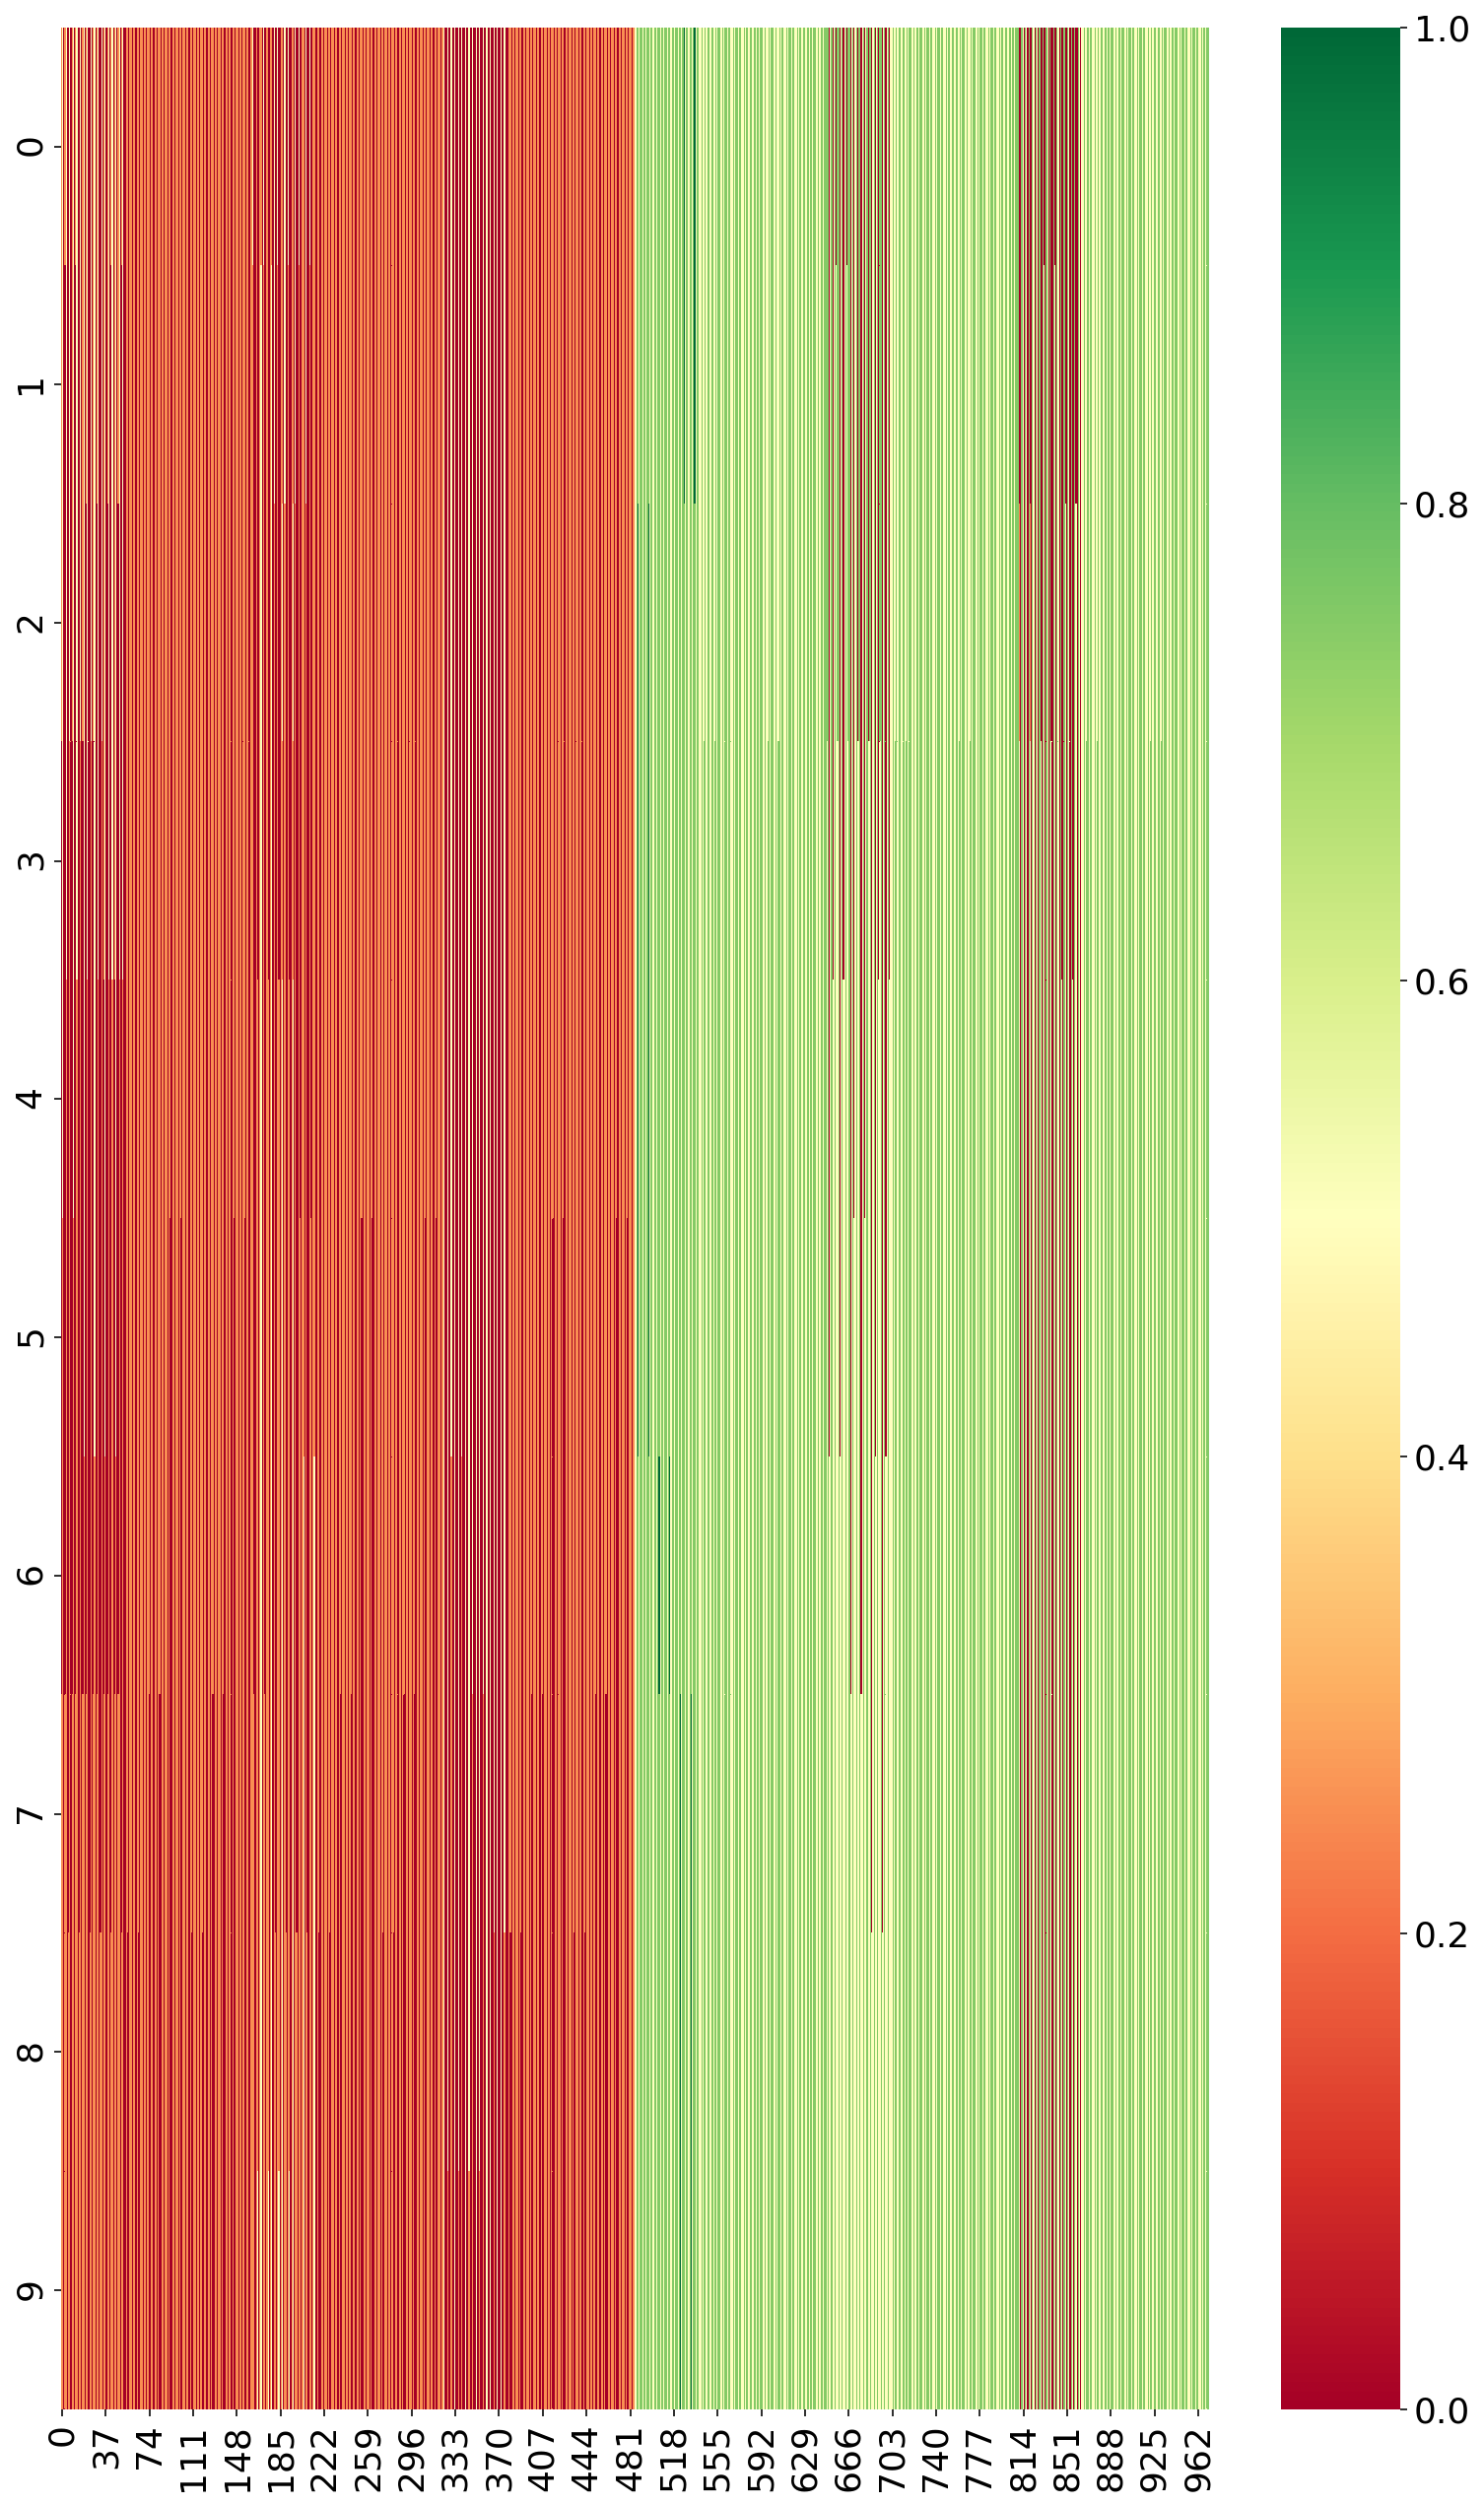

In [9]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize']=18

plt.figure(figsize=(3.6,8))
plt.rcParams["font.serif"]
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
fig = plt.figure(figsize = (11, 18))

sns.heatmap(np.array(weightpcum),cmap='RdYlGn')
fig.tight_layout()
plt.savefig("heatmap_post.pdf", dpi=600,bbox_inches='tight')

In [7]:
for i in max_list:
    print(df_active['ID'][i])

CIR50_0_33_ImmunEscp_Jul_1_00_ABW150Days_Vaccine_BestWeekAvg_SD_RARF
CIR50_0_33_ImmunEscp_Jul_1_00_ABW180Days_Vaccine_BestWeekAvg_SD_RARF


In [8]:
df_posterior = df_active.copy(deep=True)
df_posterior['WeightRMSE'] = weightr
for i in range(N):
    for j in range(731):    
        df_posterior.iloc[i,j] = df_posterior.iloc[i,j]*df_posterior['WeightRMSE'][i]


,Total,Total,Total,Total,Total,Total,Total,Total,Total,Total,...,Total,Total,Total,Total,Total,Total,Total,Total,Total,Total
0,8.512431,8.513321,8.507246,8.512397,8.513205,8.510286,8.512372,8.513115,8.511633,8.512431,...,8.606723,8.604923,8.605567,8.60663,8.60493,8.605588,8.606675,8.604938,8.605609,8.606723
1,9.632187,9.633194,9.62632,9.632148,9.633063,9.62976,9.63212,9.632961,9.631284,9.632187,...,9.737832,9.735795,9.736525,9.737727,9.735804,9.736548,9.737778,9.735812,9.736572,9.737832
2,10.504724,10.505822,10.498325,10.504682,10.505679,10.502078,10.504651,10.505569,10.50374,10.504724,...,10.617934,10.615713,10.616508,10.617819,10.615722,10.616534,10.617875,10.615732,10.61656,10.617934
3,11.291047,11.292227,11.284168,11.291001,11.292073,11.288202,11.290968,11.291954,11.289988,11.291047,...,11.410866,11.408479,11.409334,11.410743,11.408489,11.409361,11.410802,11.408499,11.409389,11.410866
4,12.07633,12.077592,12.068973,12.076281,12.077428,12.073287,12.076246,12.077301,12.075198,12.07633,...,12.201697,12.199145,12.200059,12.201565,12.199155,12.200088,12.201629,12.199166,12.200118,12.201697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Scenario,1,2,3,4,5,6,7,8,9,10,...,963,964,965,966,967,968,969,970,971,972
Date Of Peak,670,558,437,670,576,437,670,582,434,670,...,553,670,598,541,670,630,545,670,670,553
Number At Peak,2.0,172270.0,98844.0,2.0,85952.0,70227.0,2.0,13539.0,51320.0,2.0,...,625289.0,2.0,186118.0,5242426.0,2.0,47632.0,1998940.0,2.0,2.0,625289.0
LogNumAtPeak,0.30103,5.23621,4.99495,0.30103,4.934256,4.846504,0.30103,4.131587,4.710287,0.30103,...,5.796081,0.30103,5.269788,6.719532,0.30103,4.677899,6.3008,0.30103,0.30103,5.796081


In [9]:
df_posterior.transpose()

,Total,Total,Total,Total,Total,Total,Total,Total,Total,Total,...,Total,Total,Total,Total,Total,Total,Total,Total,Total,Total
0,8.512431,8.513321,8.507246,8.512397,8.513205,8.510286,8.512372,8.513115,8.511633,8.512431,...,8.606723,8.604923,8.605567,8.60663,8.60493,8.605588,8.606675,8.604938,8.605609,8.606723
1,9.632187,9.633194,9.62632,9.632148,9.633063,9.62976,9.63212,9.632961,9.631284,9.632187,...,9.737832,9.735795,9.736525,9.737727,9.735804,9.736548,9.737778,9.735812,9.736572,9.737832
2,10.504724,10.505822,10.498325,10.504682,10.505679,10.502078,10.504651,10.505569,10.50374,10.504724,...,10.617934,10.615713,10.616508,10.617819,10.615722,10.616534,10.617875,10.615732,10.61656,10.617934
3,11.291047,11.292227,11.284168,11.291001,11.292073,11.288202,11.290968,11.291954,11.289988,11.291047,...,11.410866,11.408479,11.409334,11.410743,11.408489,11.409361,11.410802,11.408499,11.409389,11.410866
4,12.07633,12.077592,12.068973,12.076281,12.077428,12.073287,12.076246,12.077301,12.075198,12.07633,...,12.201697,12.199145,12.200059,12.201565,12.199155,12.200088,12.201629,12.199166,12.200118,12.201697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Scenario,1,2,3,4,5,6,7,8,9,10,...,963,964,965,966,967,968,969,970,971,972
Date Of Peak,670,558,437,670,576,437,670,582,434,670,...,553,670,598,541,670,630,545,670,670,553
Number At Peak,2.0,172270.0,98844.0,2.0,85952.0,70227.0,2.0,13539.0,51320.0,2.0,...,625289.0,2.0,186118.0,5242426.0,2.0,47632.0,1998940.0,2.0,2.0,625289.0
LogNumAtPeak,0.30103,5.23621,4.99495,0.30103,4.934256,4.846504,0.30103,4.131587,4.710287,0.30103,...,5.796081,0.30103,5.269788,6.719532,0.30103,4.677899,6.3008,0.30103,0.30103,5.796081


In [21]:
ensemble_mean = []
weighted_mean = []
ensemble_sem = []
ensemble_ub = []
ensemble_lb = []

for i in range(731):
    ensemble_mean.append(np.mean(df_active.iloc[:,i]))
    weighted_mean.append(sum(df_posterior.iloc[:,i]))
    ensemble_sem.append(scipy.stats.sem(df_active.iloc[:,i]))
    ensemble_ub.append(ensemble_mean[i]+ensemble_sem[i])
    ensemble_lb.append(ensemble_mean[i]-ensemble_sem[i])

In [40]:
pop_v=0
weighted_sem=[]
for j in range(731):
    for i in range(N):
        pop_v += weightr[i]*((df_active.iloc[i,j]-weighted_mean[j])**2)
    weighted_sem.append(pop_v)


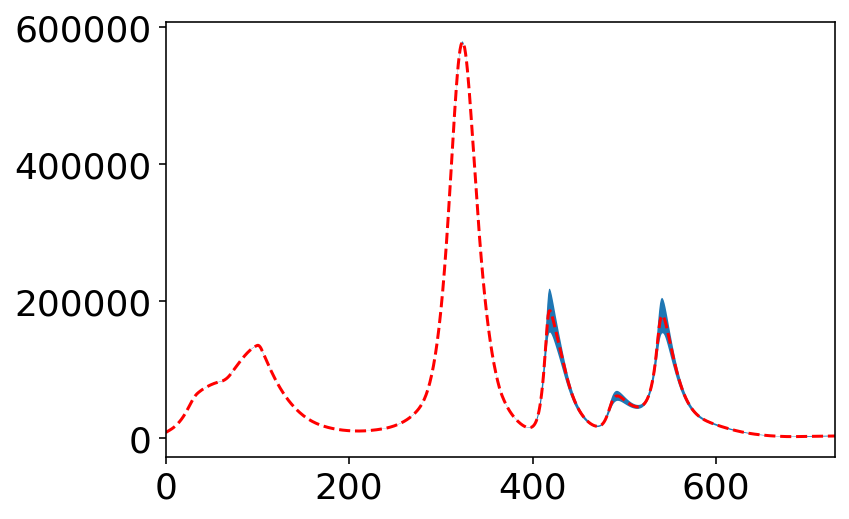

In [45]:
plt.plot(ensemble_mean, 'r--')
plt.fill_between(np.arange(0,731),ensemble_ub,ensemble_lb)
plt.xlim([0,730])

plt.show()

<Figure size 259.2x576 with 0 Axes>

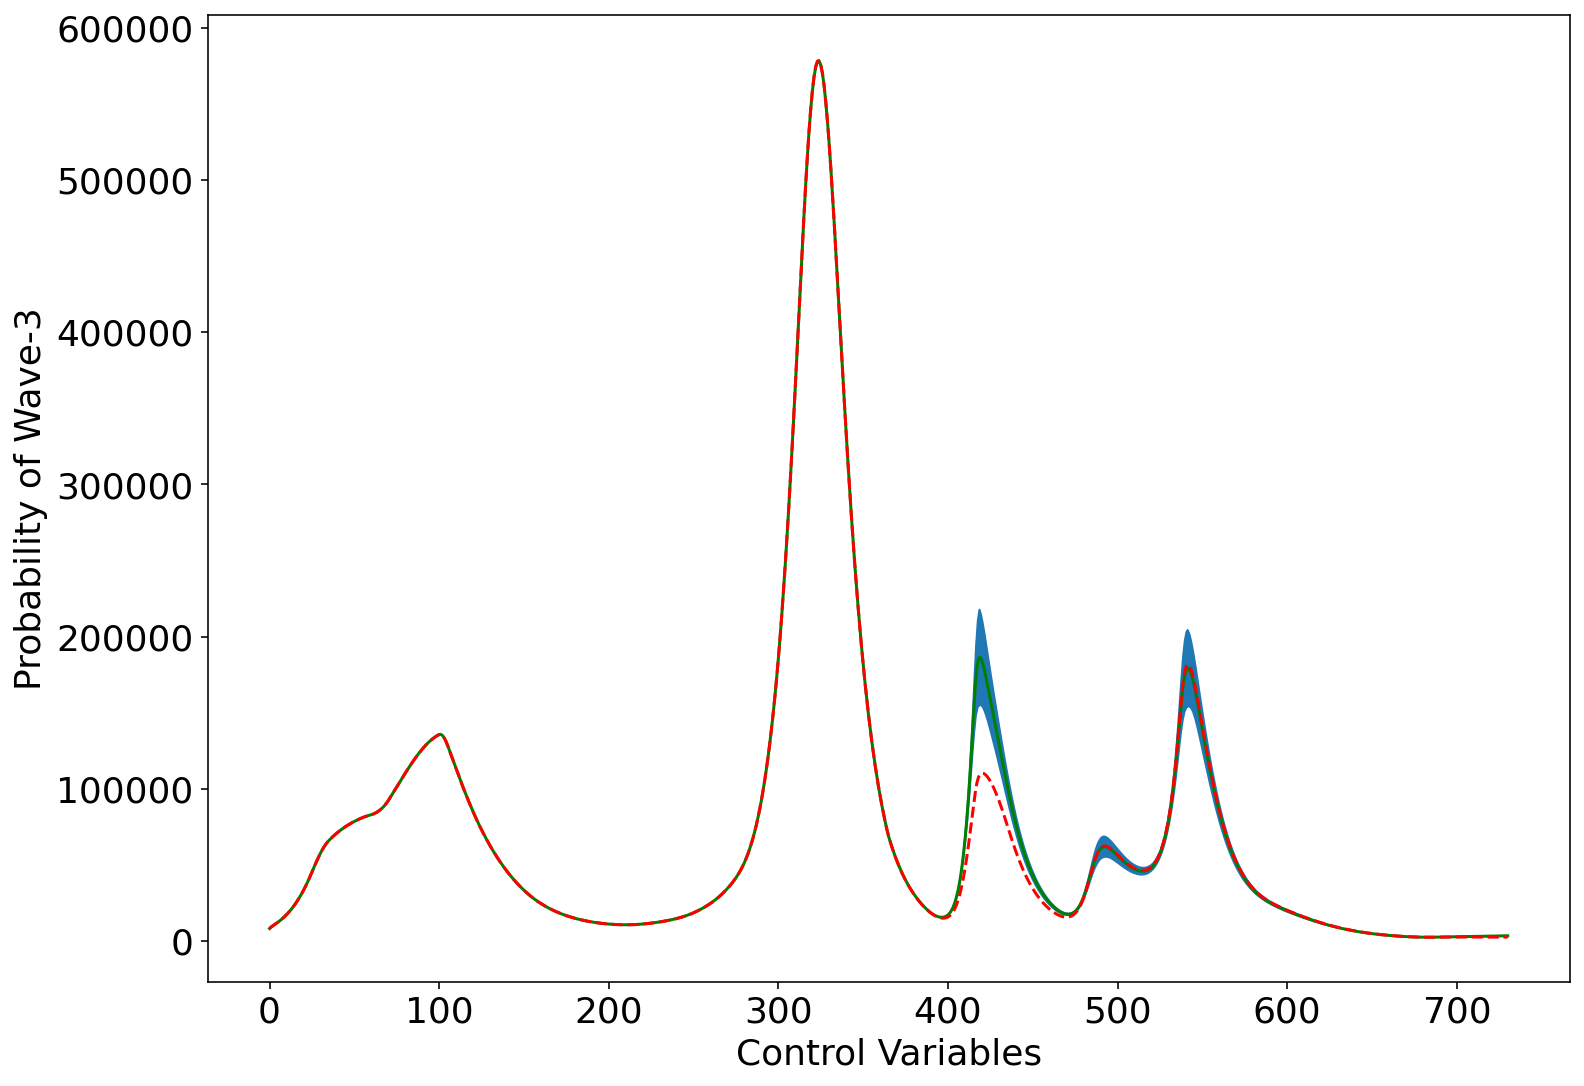

In [42]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize']=18

plt.figure(figsize=(3.6,8))
plt.rcParams["font.serif"]
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
fig = plt.figure(figsize = (11, 8))


plt.xlabel('Control Variables')
plt.ylabel('Probability of Wave-3')
# yt=[1e5,2e5,3e5,4e5,5e6,6e5]
# ytl=['100K','200K','300K','400K','500K','600K']
# plt.yticks(yt)
# fig.yticklabels(ytl)

plt.tight_layout()


plt.plot(ensemble_mean,'g')
plt.plot(weighted_mean, 'r--')
plt.fill_between(np.arange(0,731),ensemble_ub,ensemble_lb,'b')
plt.show()

